**Importing libraries**

In [ ]:
!pip install plotly
!pip install --upgrade nbformat
!pip install nltk
!pip install spacy # spaCy is an open-source software library for advanced natural language processing
!pip install WordCloud
!pip install gensim # Gensim is an open-source library for unsupervised topic modeling and natural language processing
import nltk
nltk.download('punkt')

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional
from tensorflow.keras.models import Model

**Reading the CSV file**

In [2]:
train=pd.read_csv('Train_Dataset.csv')
train.head()

,headline,is_sarcastic
0,supreme court votes 7-2 to legalize all worldl...,1
1,hungover man horrified to learn he made dozens...,1
2,emily's list founder: women are the 'problem s...,0
3,send your kids back to school with confidence,0
4,watch: experts talk pesticides and health,0


**Data cleaning**

In [3]:
train['headline'][0]

'supreme court votes 7-2 to legalize all worldly vices'

In [4]:
train.isna().sum()

headline        0
is_sarcastic    0
dtype: int64

In [5]:
len(train[train['is_sarcastic']==1])

20304

In [6]:
len(train[train['is_sarcastic']==0])

23958

In [7]:
train_sar=train[train['is_sarcastic']==1]

In [8]:
train_non=train[train['is_sarcastic']==0]

In [9]:
train_down=train_non.sample(train_sar.shape[0])
train_down.shape

(20304, 2)

In [10]:
balanced=pd.concat([train_sar,train_down])
balanced['is_sarcastic'].value_counts()

1    20304
0    20304
Name: is_sarcastic, dtype: int64

**Dividing dataset based on X and Y labels**

In [11]:
X=balanced['headline']
y=balanced['is_sarcastic']
print( X,y
)

0        supreme court votes 7-2 to legalize all worldl...
1        hungover man horrified to learn he made dozens...
6                    u.s. dignity reserves nearly depleted
8        report: there still time to convert to christi...
10       kid honors grandpa's memory with solemn cannon...
                               ...                        
27159         the u.s., cuba, and strategic foreign policy
1677     what on earth do you have to do to be kicked o...
32371    fan grabs world series home run from another f...
24570    mike tyson does his best drake impression afte...
6264     malaysia arrests north korean man as row over ...
Name: headline, Length: 40608, dtype: object 0        1
1        1
6        1
8        1
10       1
        ..
27159    0
1677     0
32371    0
24570    0
6264     0
Name: is_sarcastic, Length: 40608, dtype: int64


In [ ]:
X[0]

'supreme court votes 7-2 to legalize all worldly vices'

In [ ]:
len(X)

40608

**Removing Digits**

In [ ]:
import re

def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-Z0-9\s]' if not remove_digits else r'[^a-zA-Z\s]'
    text = re.sub(pattern, '', text)
    return text
for i in range(len(X)):
  try:
    X[i]=remove_special_characters(X[i],remove_digits=True)
  except:
    pass
X[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


'supreme court votes  to legalize all worldly vices'

In [ ]:
X

0        supreme court votes  to legalize all worldly v...
1        hungover man horrified to learn he made dozens...
6                      us dignity reserves nearly depleted
8        report there still time to convert to christia...
10       kid honors grandpas memory with solemn cannonball
                               ...                        
22659         house gop announces lawyer for obama lawsuit
27686                        mewesyria resistance and hope
39304    demi lovato and wilmer valderrama decide to gi...
7696     watch your favorite musicians perform the hami...
16960    another thing colin powell said in those leake...
Name: headline, Length: 40608, dtype: object

In [ ]:
!pip install contractions
!pip install textsearch

     |████████████████████████████████| 284 kB 4.2 MB/s 
     |████████████████████████████████| 321 kB 49.3 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85436 sha256=de58d853162eac8c48554d3e3fb0c9288fd8bc162edd28164bfa496fddac25b1
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick


**Contracting Text**

In [ ]:
import contractions
for i in range(len(X)):
  try:
    X[i]=contractions.fix(X)
  except:
    pass
X[0]

'supreme court votes  to legalize all worldly vices'

**Lemmatization**

In [ ]:
import spacy
nlp = spacy.load('en', parse=False, tag=False, entity=False)
def spacy_lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text
for i in range(len(X)):
  try:
    X[i]=spacy_lemmatize_text(X)
  except:
    pass

**Stopwords**

In [ ]:
def remove_stopwords(text, is_lower_case=False, stopwords=None):
    if not stopwords:
        stopwords = nltk.corpus.stopwords.words('english')
    tokens = nltk.word_tokenize(text)
    tokens = [token.strip() for token in tokens]
    
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopwords]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopwords]
    
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

In [ ]:
import nltk
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')
for i in range(len(X)):
  try:
    X[i]=remove_stopwords(X,is_lower_case=False,stopwords=stop_words)
  except:
    pass

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
X[0]

'supreme court votes  to legalize all worldly vices'

**Tokenizing texts**

**Splitting Dataset into training and validation**

In [13]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val = train_test_split(X,y,test_size=0.2,random_state=1)
x_train,x_test,y_train,y_test = train_test_split(x_train,y_train,test_size=0.1,random_state=1)

In [ ]:
!pip install tensorflow-text==2.7.3

**Models for evaluation**

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
pipe1=Pipeline([('lr',LogisticRegression(max_iter=10000))])
pipe2=Pipeline([('RFC',RandomForestClassifier(n_estimators=100))])
#pipe3=Pipeline([('nb',GaussianNB())])
pipe4=Pipeline([('knn',KNeighborsClassifier(n_neighbors=3))])
pipe5=Pipeline([('dtc',DecisionTreeClassifier())])

In [ ]:
pipe1.fit(x_train,y_train)
pipe2.fit(x_train,y_train)
#pipe3.fit(x_train,y_train)
pipe4.fit(x_train,y_train)
pipe5.fit(x_train,y_train)

Pipeline(steps=[('dtc', DecisionTreeClassifier())])

In [ ]:
print(pipe1.score(x_val,y_val))
print(pipe2.score(x_val,y_val))
#print(pipe3.score(x_val,y_val))
print(pipe4.score(x_val,y_val))
print(pipe5.score(x_val,y_val))

0.8742799051169096
0.9190105049135886
0.5472721111487632
0.8845589065853383


**BERT**

In [14]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub

In [15]:
!pip3 install bert-for-tf2

In [16]:
from bert import bert_tokenization as tokenization

**Preparing dataset for training**

In [17]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

**Building model for training**

In [18]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=6e-6), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

**Downloading BERT module and model**

In [19]:
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

In [20]:
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)


In [21]:
X.values

array(['supreme court votes 7-2 to legalize all worldly vices',
       'hungover man horrified to learn he made dozens of plans last night',
       'u.s. dignity reserves nearly depleted', ...,
       'fan grabs world series home run from another fan to throw it back',
       "mike tyson does his best drake impression after seeing 'hotline bling' meme",
       "malaysia arrests north korean man as row over kim jong nam's death escalates"],
      dtype=object)

In [32]:
train_input = bert_encode(X, tokenizer, max_len=256)
train_labels = y

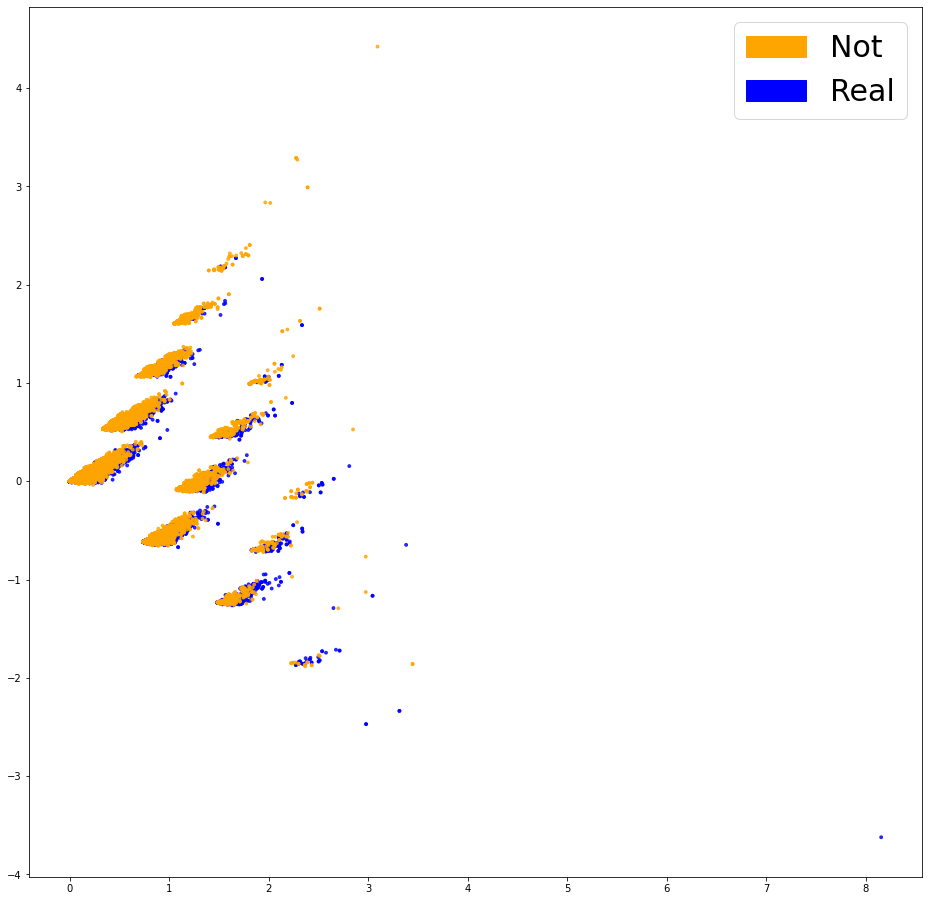

In [33]:
def cv(data):
    count_vectorizer = CountVectorizer()
    emb = count_vectorizer.fit_transform(data)
    return emb, count_vectorizer

def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            orange_patch = mpatches.Patch(color='orange', label='Not')
            blue_patch = mpatches.Patch(color='blue', label='Real')
            plt.legend(handles=[orange_patch, blue_patch], prop={'size': 30})

train_counts, count_vectorizer = cv(X)
fig = plt.figure(figsize=(16, 16))          
plot_LSA(train_counts, train_labels)
plt.show()

In [34]:
model = build_model(bert_layer, max_len=256)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


**Training of Dataset**

In [35]:
train_history = model.fit(train_input, train_labels, validation_split=0.2,
    epochs=3, batch_size=16)

Epoch 1/3
2031/2031 [==============================] - 3314s 2s/step - loss: 0.2011 - accuracy: 0.9185 - val_loss: 0.3637 - val_accuracy: 0.8700
Epoch 2/3
2031/2031 [==============================] - 3302s 2s/step - loss: 0.0397 - accuracy: 0.9872 - val_loss: 0.1781 - val_accuracy: 0.9466
Epoch 3/3
2031/2031 [==============================] - 3304s 2s/step - loss: 0.0067 - accuracy: 0.9982 - val_loss: 0.2671 - val_accuracy: 0.9429


In [36]:
final=pd.read_csv('/content/Test_Dataset.csv')
final=final['headline']
final.head()

0    area stand-up comedian questions the deal with...
1    dozens of glowing exit signs mercilessly taunt...
2    perfect response to heckler somewhere in prop ...
3                         gop prays for ossoff lossoff
4    trevor noah says the scary truth about trump's...
Name: headline, dtype: object

In [38]:
test_input = bert_encode(final, tokenizer, max_len=256)

In [39]:
test_input[:5]

(array([[  101,  2181,  3233, ...,     0,     0,     0],
        [  101,  9877,  1997, ...,     0,     0,     0],
        [  101,  3819,  3433, ...,     0,     0,     0],
        ...,
        [  101,  2045,  2003, ...,     0,     0,     0],
        [  101,  3505, 13433, ...,     0,     0,     0],
        [  101,  2129, 18551, ...,     0,     0,     0]]),
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]))

**Predicting on Test Dataset**

In [41]:
result=model.predict(test_input)
result=pd.DataFrame(result,columns=['prediction'])


In [42]:
result[:5]

,prediction
0,0.999981
1,0.999996
2,0.999989
3,0.999408
4,0.000007


In [48]:
result=result.values

In [60]:
res=[]
for i in result:
  if i<0.5:
    res.append(0)
  else:
    res.append(1)

In [61]:
result[:10]

array([[9.9998116e-01],
       [9.9999607e-01],
       [9.9998868e-01],
       [9.9940848e-01],
       [7.4792574e-06],
       [9.9989343e-01],
       [9.9995732e-01],
       [9.9990308e-01],
       [7.6200899e-06],
       [2.7161201e-05]], dtype=float32)

In [62]:
res[:10]

[1, 1, 1, 1, 0, 1, 1, 1, 0, 0]

**Converting to Pandas DataFrame**

In [63]:
res=pd.DataFrame(res,columns=['prediction'])
res.head()

,prediction
0,1
1,1
2,1
3,1
4,0


In [65]:
#Test data score is 96.37.